# RNN "Many-2-one" use-case. (seq-2-vec)

## Run sequences based on sentences.

### Dataset layout

#### Window 0:

Input: `Hello,world, ML coding!`

```python

Sample: Hello,world, ML
Label: coding

```

#### Window 1:

```python

Sample: Hello,world,
Label: ML

```


In [460]:
import tensorflow as tf
import tensorflow.keras.utils as ku 

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.activations import relu
from tensorflow.keras.activations import softmax
 
import numpy as np 

from __future__ import print_function

# Data processing

## Download the Shakespeare`s poetry.

In [461]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt

--2021-03-31 00:25:55--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 74.125.20.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2021-03-31 00:25:55 (154 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



## Read data

In [462]:
import pprint as pp

with open('/tmp/sonnets.txt') as f:
  data = f.read()
  corpus = data.lower().split("\n")

pp.pprint(corpus)

['from fairest creatures we desire increase,',
 "that thereby beauty's rose might never die,",
 'but as the riper should by time decease,',
 'his tender heir might bear his memory:',
 'but thou, contracted to thine own bright eyes,',
 "feed'st thy light'st flame with self-substantial fuel,",
 'making a famine where abundance lies,',
 'thyself thy foe, to thy sweet self too cruel.',
 "thou that art now the world's fresh ornament",
 'and only herald to the gaudy spring,',
 'within thine own bud buriest thy content',
 'and, tender churl, makest waste in niggarding.',
 'pity the world, or else this glutton be,',
 "to eat the world's due, by the grave and thee.",
 'when forty winters shall beseige thy brow,',
 "and dig deep trenches in thy beauty's field,",
 "thy youth's proud livery, so gazed on now,",
 "will be a tatter'd weed, of small worth held:",
 "then being ask'd where all thy beauty lies,",
 'where all the treasure of thy lusty days,',
 'to say, within thine own deep-sunken eyes,',

## Tokenize data into sequences 

In [463]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


pp.pprint(input_sequences)

流式输出内容被截断，只能显示最后 5000 行内容。
 [153, 5, 174],
 [153, 5, 174, 3],
 [153, 5, 174, 3, 856],
 [153, 5, 174, 3, 856, 857],
 [66, 209],
 [66, 209, 2595],
 [66, 209, 2595, 287],
 [66, 209, 2595, 287, 150],
 [66, 209, 2595, 287, 150, 2596],
 [858, 206],
 [858, 206, 1],
 [858, 206, 1, 1299],
 [858, 206, 1, 1299, 13],
 [858, 206, 1, 1299, 13, 23],
 [858, 206, 1, 1299, 13, 23, 5],
 [858, 206, 1, 1299, 13, 23, 5, 400],
 [858, 206],
 [858, 206, 1],
 [858, 206, 1, 1299],
 [858, 206, 1, 1299, 2597],
 [858, 206, 1, 1299, 2597, 3],
 [858, 206, 1, 1299, 2597, 3, 160],
 [858, 206, 1, 1299, 2597, 3, 160, 249],
 [1, 7],
 [1, 7, 29],
 [1, 7, 29, 205],
 [1, 7, 29, 205, 13],
 [1, 7, 29, 205, 13, 5],
 [1, 7, 29, 205, 13, 5, 488],
 [1, 7, 29, 205, 13, 5, 488, 411],
 [348, 2598],
 [348, 2598, 7],
 [348, 2598, 7, 66],
 [348, 2598, 7, 66, 26],
 [348, 2598, 7, 66, 26, 1298],
 [348, 2598, 7, 66, 26, 1298, 471],
 [348, 2598, 7, 66, 26, 1298, 471, 1258],
 [858, 206],
 [858, 206, 1],
 [858, 206, 1, 75],
 [858, 206, 1, 75,

# Create dataset

In [464]:
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = (pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

pp.pprint(input_sequences)

array([[   0,    0,    0, ...,    0,   34,  417],
       [   0,    0,    0, ...,   34,  417,  877],
       [   0,    0,    0, ...,  417,  877,  166],
       ...,
       [   0,    0,    0, ...,  493,  493, 3210],
       [   0,    0,    0, ...,  493, 3210,   15],
       [   0,    0,    0, ..., 3210,   15,   14]], dtype=int32)


## Make sample(x) and label(y)

In [465]:
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
label = ku.to_categorical(label, num_classes=total_words)

### Dispay sample and label

In [466]:
print("Sample: {}".format(predictors.shape))
pp.pprint(predictors)

Sample: (15462, 10)
array([[   0,    0,    0, ...,    0,    0,   34],
       [   0,    0,    0, ...,    0,   34,  417],
       [   0,    0,    0, ...,   34,  417,  877],
       ...,
       [   0,    0,    0, ..., 3209,  493,  493],
       [   0,    0,    0, ...,  493,  493, 3210],
       [   0,    0,    0, ...,  493, 3210,   15]], dtype=int32)


In [467]:
print("Label: {}".format(label.shape))
pp.pprint(label)

Label: (15462, 3211)
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)


# Machine-learning

## Hyperparemeters

In [468]:
embeding_dim = 215
rnn_units = 64
dropout = .2
epochs = 150

## Create model, predict method and graphic tool

In [469]:
def build_model():
  model = Sequential()

  model.add(Embedding(input_dim=total_words, 
                      output_dim=embeding_dim,
                      input_length=max_sequence_len - 1))
  model.add(tf.keras.layers.AveragePooling1D())
  model.add(Bidirectional(LSTM(units=rnn_units, return_sequences=True)))
  model.add(Dropout(dropout))
  model.add(LSTM(units=rnn_units))
  model.add(Dense(total_words, activation=relu, 
                  kernel_regularizer=tf.keras.regularizers.l2(0.01)))
  model.add(Dense(total_words, activation=softmax))

  model.compile(loss=CategoricalCrossentropy(), 
                optimizer=Adam(), 
                metrics=['accuracy'])
  print(model.summary())

  return model

model = build_model()

Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_70 (Embedding)     (None, 10, 215)           690365    
_________________________________________________________________
average_pooling1d_27 (Averag (None, 5, 215)            0         
_________________________________________________________________
bidirectional_38 (Bidirectio (None, 5, 128)            143360    
_________________________________________________________________
dropout_43 (Dropout)         (None, 5, 128)            0         
_________________________________________________________________
lstm_107 (LSTM)              (None, 64)                49408     
_________________________________________________________________
dense_97 (Dense)             (None, 3211)              208715    
_________________________________________________________________
dense_98 (Dense)             (None, 3211)            

In [470]:
def predict(model, next_words=100):
  seed_text = "Help me Obi Wan Kenobi, you're my only hope"
    
  for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = np.argmax(model.predict(token_list), axis=-1)
    output_word = ""
    for word, index in tokenizer.word_index.items():
      if index == predicted:
        output_word = word
        break
    seed_text += " " + output_word
  print(seed_text)

In [471]:
def plot(history):
  import matplotlib.pyplot as plt
  
  acc = history.history['accuracy']
  loss = history.history['loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', label='Training accuracy')
  plt.title('Training accuracy')

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training Loss')
  plt.title('Training loss')
  plt.legend()

  plt.show()

## Try untrained model

In [472]:
predict(model)

Help me Obi Wan Kenobi, you're my only hope rosy grievances about about about where dignifies bristly bristly eclipses doctor doctor believed believed believed prevailed presents presents fairest satire satire satire satire yellow'd yellow'd tyrannous tyrannous say born plot born truth still enclose enclose youthful youthful would would after after boughs brand affections affections affections youth youth distemper'd distemper'd growth youth youth windy youth youth youth linger youth windy windy use inward use inward inward feature nurse sings grievances beyond engrafted changing changing form presents form affections sure satire satire satire dignifies dignifies brains brand brand if if barrenly dignifies perceivest perceivest zealous sue gives eyes dignifies perceivest perceivest


## Train model

In [473]:
print("X: {}".format(predictors.shape))
pp.pprint(predictors)
print("Y: {}".format(label.shape))
pp.pprint(label)

X: (15462, 10)
array([[   0,    0,    0, ...,    0,    0,   34],
       [   0,    0,    0, ...,    0,   34,  417],
       [   0,    0,    0, ...,   34,  417,  877],
       ...,
       [   0,    0,    0, ..., 3209,  493,  493],
       [   0,    0,    0, ...,  493,  493, 3210],
       [   0,    0,    0, ...,  493, 3210,   15]], dtype=int32)
Y: (15462, 3211)
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)


In [474]:
history = model.fit(predictors, label, epochs=epochs, verbose=1)

Epoch 1/150
484/484 [==============================] - 11s 15ms/step - loss: 7.2224 - accuracy: 0.0180
Epoch 2/150
484/484 [==============================] - 7s 14ms/step - loss: 6.4955 - accuracy: 0.0247
Epoch 3/150
484/484 [==============================] - 7s 15ms/step - loss: 6.4393 - accuracy: 0.0272
Epoch 4/150
484/484 [==============================] - 7s 15ms/step - loss: 6.3283 - accuracy: 0.0241
Epoch 5/150
484/484 [==============================] - 7s 15ms/step - loss: 6.2595 - accuracy: 0.0318
Epoch 6/150
484/484 [==============================] - 7s 15ms/step - loss: 6.1404 - accuracy: 0.0329
Epoch 7/150
484/484 [==============================] - 7s 15ms/step - loss: 6.1030 - accuracy: 0.0346
Epoch 8/150
484/484 [==============================] - 7s 14ms/step - loss: 6.0481 - accuracy: 0.0394
Epoch 9/150
484/484 [==============================] - 7s 14ms/step - loss: 5.9601 - accuracy: 0.0393
Epoch 10/150
484/484 [==============================] - 7s 14ms/step - loss: 5.88

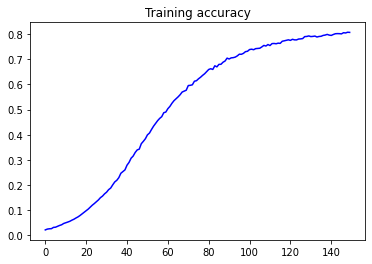

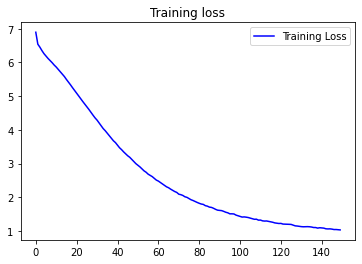

In [475]:
plot(history)

## Verfiy model

In [476]:
predict(model)

Help me Obi Wan Kenobi, you're my only hope doth stay show to them thee still me must thee be scanted was so truth one parts of fled stay right of go pride alone find away those doth stay seen prove store stay and white end end confound hits sky confound confound impute strife blindness themselves common part thee still to bold make me grow such power part one outworn ' to see devised thee mine and knew die you none see sole aside growth still day ' to to prove one grow end dyed wrong sole past staineth staineth crave affords thinly ranged nearly ranged thinly contents see
